# Semplice introduzione alla libreria ```transformers```

La libreria ```transformers``` viene installata semplicemente utilizzando ```pip```:

```bash
$ pip install transformers
```

E' necessario avere i driver ```CUDA```installati e ovviamente ```PyTorch```.

```transformers``` si fonda su tre concetti di base: il modello, il tokenizer a questo associato e possibilmente la configurazione in caso di modelli pre-addestrati. Ogni modello/tokenizer può essere richiamato con la sua classe specifica (ad esempio ```BertModel```) o tramite le classi ```AutoModel``` e ```AutoTokenizer``` che automaticamente instanziano l'oggetto corrispondente al nome del modello così com'è definito su huggingface.

La classe ```PreTrainedConfig``` contiene le eventuali opzionidi configurazione (numero di teste, numero di stati nascosti, weight tying, parametri per il back-end PyTorch e così via). Vediamo alcuni esempi.
```python
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
```
---
```python
from transformers import AutoConfig, AutoModel

# Download configuration from huggingface.co and cache.
config = AutoConfig.from_pretrained("google-bert/bert-base-cased")
model = AutoModel.from_config(config)
```
---
```python
from transformers import AutoConfig
config = AutoConfig.from_pretrained("google-bert/bert-base-cased")
# Push the config to your namespace with the name "my-finetuned-bert".
config.push_to_hub("my-finetuned-bert")
# Push the config to an organization with the name "my-finetuned-bert".
config.push_to_hub("huggingface/my-finetuned-bert")
```
E' anche possibile regstrare i propri modelli e usarli poi con le classi ```Auto```.

```python
from transformers import AutoConfig, AutoModel
AutoConfig.register("new-model", NewModelConfig)
AutoModel.register(NewModelConfig, NewModel)
```
Mentre la classe ```AutoModel``` fa riferimento a modelli che restituiscono embeddings, esistono anche le classi di modelli orientati al task come ad es. ```AutoModelForSequenceClassification``` oppure ```BertForNextSentencePrediction``` che sono esplicitamente corredati di una testa neurale dedicata all'apprendimento del task in oggetto.
Dalla [documentazione](https://huggingface.co/docs/transformers/index) potete vedere tutte le classi e i modelli disponibili. 

Per il caricamento di un modello via classi ```Auto``` di cui si conosce il nome, ma non l'esatta dicitura, cercare il modello su [huggingface](https://huggingface.co/), andare sulla scheda del modello con il nome per il caricamento sul codice python, con descrizione e codice di esempio (vedi ad esempio la [scheda](https://huggingface.co/roberta-base) di RoBERTa il cui nome del modello da inserire nel codice è `roberta-base`)

In [3]:
from transformers import AutoConfig, AutoModel, AutoTokenizer

model_name = "bert-base-uncased"
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, config=config) 

In [4]:
# come funziona il tokenizzatore di BERT

text = 'The quick brown fox, jumps over: the lazy dog.'
print(f"Tokenizzazione di '{text}'")
print(f"s ha {len(text)} caratteri")
tokens = tokenizer.tokenize(text)
print(f"Abbiamo ottenuto {len(tokens)} token:\n{tokens}")


Tokenizzazione di 'The quick brown fox, jumps over: the lazy dog.'
s ha 46 caratteri
Abbiamo ottenuto 12 token:
['the', 'quick', 'brown', 'fox', ',', 'jumps', 'over', ':', 'the', 'lazy', 'dog', '.']


Il ```tokenizer``` che abbiamo ottenuto è il costruttore della classe del modello corrispondente a quello che abbiamo richiesto con il metodo ```from_pretrained()```.

L'invocazione di questo costruttore restituisce un oggetto di classe ```BatchEncoding``` che sostanzialmente è un dizionario che contiene gli ID dei token da fornire in ingresso al modello che possono essere opzionalmente restituiti come tensori TF/PyTorch o come numpy array. Inoltre abbiamo anche la possibilità di ottenere la maschera di attenzione.

In [5]:
# Il tokenizer ottenuto è un costruttore selezionato dalla classe corretta 
# tk = tokenizer(s, add_special_tokens=True, return_tensors="pt")
# restituisce un oggetto di classe BatchEncoding con i seguenti campi
# input_ids -> tokens numerici
# token_type_ids -> 0 s è la prima frase, 1 se è la  seconda
# attention_mask -> 1 per i token da processare effettivamente

def show_token_info(tk):
    
    tensors = not isinstance(tk['input_ids'], list)
    print("--- RIEPILOGO TOKENIZZATORE ---")
    
    print(f"Tensori in output: {'sì' if tensors else 'no'}")
    print(f"Lista dei token: oggetto {type(tk['input_ids'])}, con dimensione {tk['input_ids'].shape if tensors else len(tk['input_ids'])}:\n")
    print(f" {tk['input_ids']}")
    print('*'*9)

    print(f"Maschera di attenzione: oggetto {type(tk['attention_mask'])} con dimensione {tk['attention_mask'].shape if tensors else len(tk['attention_mask'])}:\n")
    print(tk['attention_mask'])
    print('*'*9)

    print(f"Lista dei tipi di token (0 -> frase 1, 1 -> frase 2): {tk['token_type_ids']}\n")


tk = tokenizer(text,                        # stringa da tokenizzare
               add_special_tokens=True,     # aggiungiamo i token speciali come [MASK], [CLS], [SEP]
               return_tensors="pt")         # restituiamo i tensori PyTorch

show_token_info(tk)

tk_no_special = tokenizer(text, add_special_tokens=False)

show_token_info(tk_no_special)


--- RIEPILOGO TOKENIZZATORE ---
Tensori in output: sì
Lista dei token: oggetto <class 'torch.Tensor'>, con dimensione torch.Size([1, 14]):

 tensor([[  101,  1996,  4248,  2829,  4419,  1010, 14523,  2058,  1024,  1996,
         13971,  3899,  1012,   102]])
*********
Maschera di attenzione: oggetto <class 'torch.Tensor'> con dimensione torch.Size([1, 14]):

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
*********
Lista dei tipi di token (0 -> frase 1, 1 -> frase 2): tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

--- RIEPILOGO TOKENIZZATORE ---
Tensori in output: no
Lista dei token: oggetto <class 'list'>, con dimensione 12:

 [1996, 4248, 2829, 4419, 1010, 14523, 2058, 1024, 1996, 13971, 3899, 1012]
*********
Maschera di attenzione: oggetto <class 'list'> con dimensione 12:

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
*********
Lista dei tipi di token (0 -> frase 1, 1 -> frase 2): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



In [6]:
s = ['The quick brown fox',
     'jumps over: t',
     'The quick brown fox, jumps']

tk_1 = tokenizer(s, add_special_tokens=True, return_tensors="pt", padding=True)          # batch di tre frasi
tk_2 = tokenizer(s, add_special_tokens=False, return_tensors="pt", padding=True)
tk_3 = tokenizer(s[0], s[1], add_special_tokens=True, return_tensors="pt", padding=True) # due frasi in modalità NSP

show_token_info(tk_1)
show_token_info(tk_2)
show_token_info(tk_3)

# Estraiamo la lista dei token dal tensore che li contiene e decodifichiamoli come stringa

input_ids = [tok.item() for tok in tk_3['input_ids'][0]]

print(f" {input_ids} --> {tokenizer.decode(input_ids)}")


--- RIEPILOGO TOKENIZZATORE ---
Tensori in output: sì
Lista dei token: oggetto <class 'torch.Tensor'>, con dimensione torch.Size([3, 8]):

 tensor([[  101,  1996,  4248,  2829,  4419,   102,     0,     0],
        [  101, 14523,  2058,  1024,  1056,   102,     0,     0],
        [  101,  1996,  4248,  2829,  4419,  1010, 14523,   102]])
*********
Maschera di attenzione: oggetto <class 'torch.Tensor'> con dimensione torch.Size([3, 8]):

tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])
*********
Lista dei tipi di token (0 -> frase 1, 1 -> frase 2): tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]])

--- RIEPILOGO TOKENIZZATORE ---
Tensori in output: sì
Lista dei token: oggetto <class 'torch.Tensor'>, con dimensione torch.Size([3, 6]):

 tensor([[ 1996,  4248,  2829,  4419,     0,     0],
        [14523,  2058,  1024,  1056,     0,     0],
        [ 1996,  4248,  2829,  4419,  1010, 1

Analogamente al tokenizzatore il modello restituisce un oggetto della classe ```ModelOutput``` che contiene l'ultimo stato nascosto del modello (```last_hidden_state```) e opzionalmente _tutti_ gli stati nascosti e i loro embedding posizionali (```hidden_states```) e le maschere di attenzione (```attentions```).

In [7]:
outputs = model(tk_3['input_ids'], attention_mask=tk_3['attention_mask'])
last_hidden_states = outputs.last_hidden_state

# Dimensione (n, l, d)
# n: dimensione del batch
# l: lunghezza massima inclusiva del padding
# d: dimensione degli embedding

print(f"Ultimo stato nascosto:\n\nDimensione: {last_hidden_states.shape}\nElementi: {last_hidden_states}")


Ultimo stato nascosto:

Dimensione: torch.Size([1, 11, 768])
Elementi: tensor([[[-0.2340,  0.1555,  0.0948,  ..., -0.1905,  0.2370,  0.5643],
         [-0.2995, -0.3587, -0.1299,  ..., -0.1374,  0.6424, -0.1426],
         [-0.4934, -0.5428,  0.8112,  ..., -0.0344,  0.5537, -0.2284],
         ...,
         [ 0.3366,  0.2101,  0.0986,  ..., -0.2992,  0.2286,  0.6258],
         [ 0.6069, -0.1552,  0.6184,  ..., -0.2121,  0.5663,  0.3355],
         [ 0.7634,  0.2957, -0.3501,  ..., -0.0774, -0.5930, -0.3281]]],
       grad_fn=<NativeLayerNormBackward0>)


In [8]:
# Stampiamo tutte le informazioni sul modello
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

L'ultimo elemento che caratterizza la libreria ```transformer``` sono le pipeline: si tratta di astrazioni che consentono di creare flussi di processo in cui si inseriscono diversi componenti. 

Una pipeline è caratterizzata da un task che può essere di tipo NLP, audio prpocessing, computer vision o genericamente di estrazione di feature, cioè l'utilizzo di un modello senza testa neurale per ottenere direttamente gli embedding dell'ultimo stato nascosto. Di seguito si può consultare la [lista dei task](https://huggingface.co/docs/transformers/main/en/task_summary).

Oltre al task, la funzione ```pipeline``` accetta il modello di riferimento, il tokenizzatore ed altri argomenti non sempre necessari come la configurazione del modello, il framework neurale di riferimento (```'pt'/'tf'``` per PyTorch o Tensorflow) l'indicazione di processori dedicati per i dati, il device di destinazione e così via. Il risultato è un oggetto pipeline specifico per il task, per esempio il task ```feature-extraction``` restituisce un oggetto di classe ```FeatureExtractionPipeline```.

In [9]:
# Creiamo una pipeline identica al modello che abbiamo già caricato in precedenza
from transformers import pipeline

task = "feature-extraction"
tokenizer = AutoTokenizer.from_pretrained(model_name)

feature_extractor = pipeline(task = task, 
                             model=model_name, 
                             tokenizer=tokenizer)

result = feature_extractor(text, return_tensors=True)  # ci facciamo restituire la lista dei tensori degli embedding

# Invochiamo il modello caricato precedentemente con il primo tokenizzatore
out_no_pipe = model(tk['input_ids'], attention_mask=tk['attention_mask'])
lhs_no_pipe = out_no_pipe.last_hidden_state

Device set to use cuda:0


In [10]:
print(result)

print(lhs_no_pipe)

tensor([[[-0.5449, -0.0099, -0.3117,  ..., -0.2595,  0.4935,  0.5315],
         [-0.4142, -0.4263, -0.3243,  ..., -0.0633,  1.3985, -0.1521],
         [-0.5988, -0.4446,  0.6228,  ..., -0.0395,  0.3968, -0.1668],
         ...,
         [ 0.2650,  0.2589,  0.1067,  ..., -0.2739,  0.3995,  0.4982],
         [-0.9317, -0.5384, -0.3776,  ...,  0.5825,  0.4579, -0.5600],
         [ 0.6834,  0.2844, -0.5239,  ...,  0.0819, -0.5736, -0.3002]]])
tensor([[[-0.5449, -0.0099, -0.3117,  ..., -0.2595,  0.4935,  0.5315],
         [-0.4142, -0.4263, -0.3243,  ..., -0.0633,  1.3985, -0.1521],
         [-0.5988, -0.4446,  0.6228,  ..., -0.0395,  0.3968, -0.1668],
         ...,
         [ 0.2650,  0.2589,  0.1067,  ..., -0.2739,  0.3995,  0.4982],
         [-0.9317, -0.5384, -0.3776,  ...,  0.5825,  0.4579, -0.5600],
         [ 0.6834,  0.2844, -0.5239,  ...,  0.0819, -0.5736, -0.3002]]],
       grad_fn=<NativeLayerNormBackward0>)


Utilizziamo il modello BERT appena analizzato come feature extractor per il task di analisi del data set della BBC

In [11]:
# Importiamo le librerie

import pandas as pd
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from torch import nn
from torch.optim import Adam
import torch

In [12]:
# Carichiamo il data set e creiamo i corpora di addestramento, validazione e test
from sklearn.model_selection import train_test_split

root = "/home/rpirrone/src/"                         # Inserire il proprio percorso
df = pd.read_csv(root+"bbc-text.csv")

# Eseguiamo il mapping tra le categorie e le classi numeriche ed aggiungiamo la colonna al data set
labels_dict = {
    'business': 0,
    'politics': 1,
    'tech': 2,
    'sport': 3,
    'entertainment': 4
}

df['labels'] = df.apply(lambda row: labels_dict[row.category], axis = 1)

(x_train, x_test, y_train, y_test) = train_test_split(
    df['text'], df['labels'], test_size=0.2, random_state=17)

(x_train, x_val, y_train, y_val) = train_test_split(
    x_train, y_train, test_size=0.1, random_state=17)

# sarebbe uno split 80-20 con un 10% del training set (8% dei campioni) come validation set

In [13]:
# Creiamo il Dataset personalizzato per il nostro task

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, stopwords):

        # x e y sono series di pandas
        tokens_litt = [nltk.word_tokenize(text, language='english')
         for text in list(x)]
        text_clean = []

        if stopwords:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence if
                    not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio

        self.texts = text_clean
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_labels = np.array(self.labels[idx])

        return batch_texts, batch_labels

[nltk_data] Downloading package punkt to /home/rpirrone/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/rpirrone/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rpirrone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Classe di Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss      # consideriamo la loss corrente
                                                            # come nuova loss ottimale
            self.counter = 0                                # e azzeriamo il contatore di pazienza


In [15]:
# funzione di utilità di generazione degli embedding da inserire nel loop di training

def gen_embeddings(input_id_text, attention_mask, lm_model):
    with torch.no_grad():                               # non deriviamo rispetto al modello perché è frozen
        last_hidden_states = lm_model(input_id_text, 
                                      attention_mask=attention_mask).last_hidden_state
    
        last_hidden_states = last_hidden_states[:,0,:]  # consideriamo solo il primo degli embedding di uscita
                                                        # cioè quello del token [CLS]
    
    return last_hidden_states

In [16]:
# train loop per un'epoca
def train_loop(model, dataloader, tokenizer, lm_model, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 512, truncation=True)
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
        batch_labels = batch_labels.to(device)
        embeddings_texts = gen_embeddings(input_id_texts, mask_texts, lm_model)
        output = model(embeddings_texts)

        # la loss è una CrossEntropyLoss, al suo interno ha
        # la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni
        # applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        embeddings_texts = embeddings_texts.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [17]:
# test loop per un'epoca
def test_loop(model, dataloader, tokenizer, lm_model, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                               return_tensors='pt', padding='max_length', max_length = 512, truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            batch_labels = batch_labels.to(device)
            embeddings_texts = gen_embeddings(input_id_texts, mask_texts, lm_model)
            output = model(embeddings_texts)

            # la loss è una CrossEntropyLoss, al suo interno ha
            # la logsoftmax + negative log likelihood loss
            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            # per calcolare l'accuracy devo generare le predizioni
            # applicando manualmente la logsoftmax
            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

            batch_labels = batch_labels.detach().cpu()
            embeddings_texts = embeddings_texts.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [18]:
def train_test(model, 
               epochs, 
               optimizer, 
               device, 
               train_data, 
               test_data,
               batch_size, 
               model_name, 
               train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addestrare senza early stopping
               val_data=None,             # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    # Carichiamo il modello transformer
    config = AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    lm_model = AutoModel.from_pretrained(model_name, config=config).to(device)

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, lm_model, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc = test_loop(model,
                                                                    val_dataloader, 
                                                                    tokenizer, 
                                                                    lm_model, 
                                                                    test_loss_fn, 
                                                                    device)
                
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        epoch_test_loss, epoch_test_acc,= test_loop(model, test_dataloader, tokenizer, lm_model, test_loss_fn, device)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str} Test loss: {epoch_test_loss:6.4f}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")

        # early stopping
        if early_stopping != None:
            early_stopping(epoch_validate_loss)
            if early_stopping.early_stop:
                break

    return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc

In [19]:
# Impostiamo il dizionario degli iperparametri
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.1,
    "stopwords": False,
    "language_model": "bert-base-uncased",
    "layers": 1,
    "h_dim": 768,
    "patience": 5,
    "min_delta": 0.01
}

In [20]:
# Creiamo i data set

train_dataset = Dataset(x_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, y_test, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 445/445 [00:00<00:00, 36212.51it/s]


In [21]:
# classe della rete che farà da testa addestrabile per BERT

class ClassifierDeep(nn.Module):

    def __init__(self, labels, hdim, dropout):
        super(ClassifierDeep, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(hdim, hdim),
            nn.BatchNorm1d(hdim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hdim, labels),
            )

    def forward(self, input_texts):
        return self.classifier(input_texts)

In [22]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = ClassifierDeep(len(labels_dict), hyperparameters["h_dim"], hyperparameters["dropout"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.CrossEntropyLoss()       #loss per il training e per il test

optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])

Using cuda device
ClassifierDeep(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=768, out_features=5, bias=True)
  )
)
Numbero totale dei parametri: 595973


In [23]:
# Routine di addestramento
train_loss, validation_loss,test_loss,train_acc, validation_acc, test_acc = train_test(model, 
                                                                                       hyperparameters['epochs'], 
                                                                                       optimizer, 
                                                                                       device, 
                                                                                       train_dataset,
                                                                                       test_dataset, 
                                                                                       hyperparameters['batch_size'], 
                                                                                       hyperparameters['language_model'], 
                                                                                       criterion, 
                                                                                       criterion, 
                                                                                       early_stopping, 
                                                                                       val_dataset)

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_2692767/4040330020.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch_labels = np.array(self.labels[idx])
 20%|██        | 1/5 [00:11<00:47, 11.77s/it]


Train loss: 0.2705 Validation loss: 0.1185  Test loss: 0.0928
Train accuracy: 0.9089 Validation accuracy: 0.9775 Test accuracy: 0.9798


 40%|████      | 2/5 [00:23<00:35, 11.70s/it]


Train loss: 0.0599 Validation loss: 0.0968  Test loss: 0.0818
Train accuracy: 0.9844 Validation accuracy: 0.9719 Test accuracy: 0.9685


 60%|██████    | 3/5 [00:35<00:23, 11.73s/it]


Train loss: 0.0374 Validation loss: 0.0916  Test loss: 0.0753
Train accuracy: 0.9931 Validation accuracy: 0.9663 Test accuracy: 0.9798


 80%|████████  | 4/5 [00:46<00:11, 11.74s/it]


Train loss: 0.1058 Validation loss: 0.0932  Test loss: 0.0698
Train accuracy: 0.9963 Validation accuracy: 0.9719 Test accuracy: 0.9798


100%|██████████| 5/5 [00:58<00:00, 11.77s/it]


Train loss: 0.0188 Validation loss: 0.0967  Test loss: 0.0824
Train accuracy: 0.9956 Validation accuracy: 0.9719 Test accuracy: 0.9730


(0.0, 1.0)

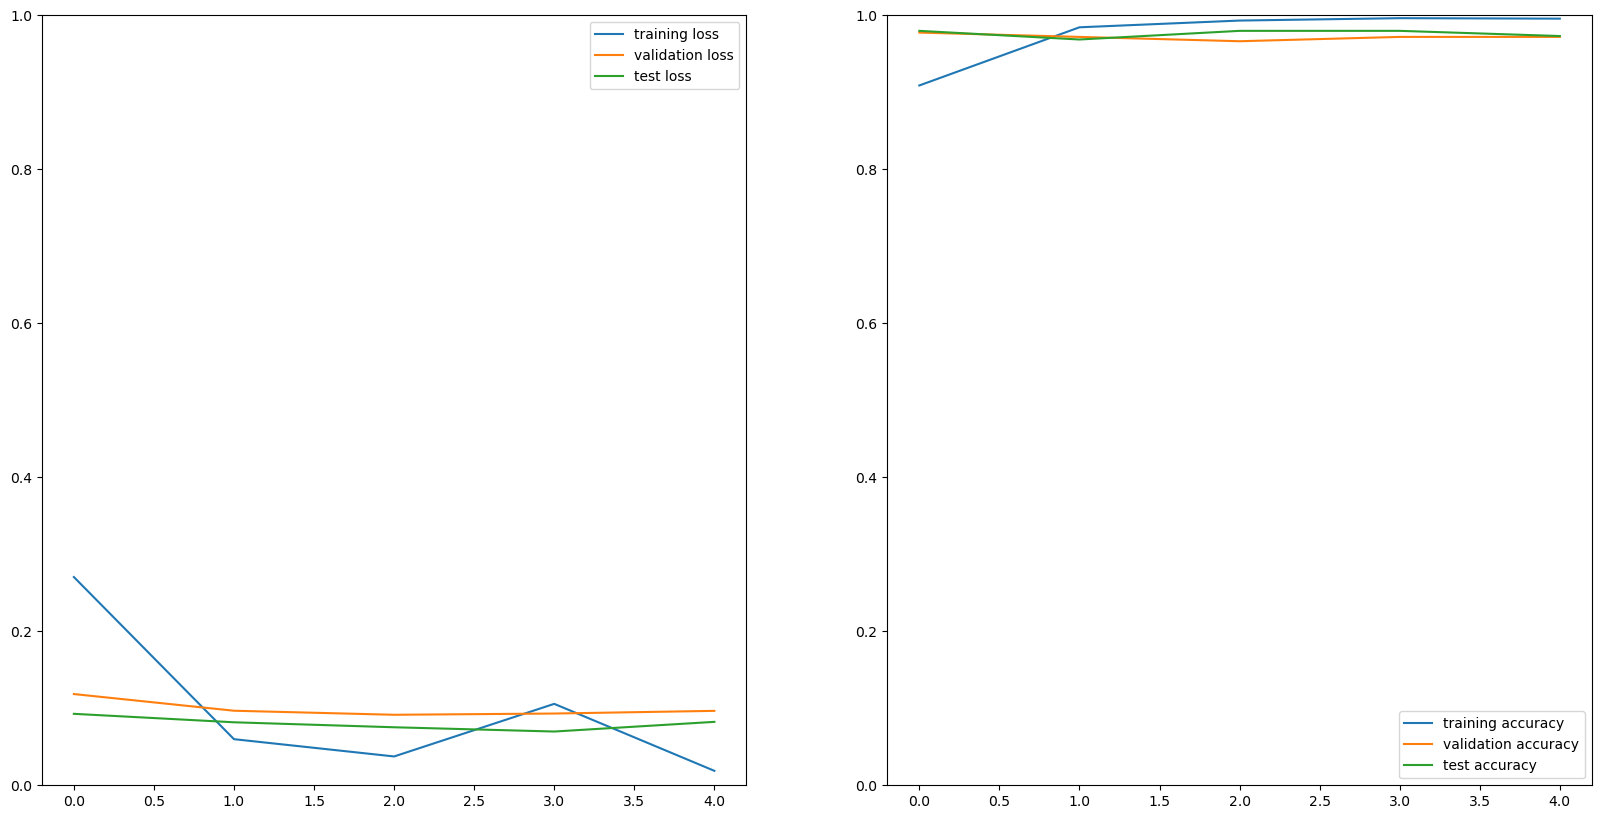

In [24]:
# Mostriamo gli esiti dell'addestramento
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(train_loss, label='training loss')
axs[0].plot(validation_loss, label='validation loss')
axs[0].plot(test_loss, label='test loss')
axs[0].legend(loc='upper right')
axs[0].set_ylim(0,1)

axs[1].plot(train_acc, label='training accuracy')
axs[1].plot(validation_acc, label='validation accuracy')
axs[1].plot(test_acc, label='test accuracy')
axs[1].legend(loc='lower right')
axs[1].set_ylim(0,1)